# QAQC order and single function testing

## Import libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Import QAQC libraries

In [2]:
import os
import tempfile
import argparse 

# Import all qaqc script functions
try:
    from qaqc_plot import *
    from qaqc_utils import *
    from qaqc_wholestation import *
    from qaqc_logic_checks import *
    from qaqc_buoy_check import *
    from qaqc_frequent import *
    from qaqc_unusual_gaps import *
    from qaqc_unusual_large_jumps import *
    from qaqc_climatological_outlier import *
    from qaqc_unusual_streaks import *
except Exception as e:
    print("Error importing qaqc script: {}".format(e))

# Import qaqc stage calc functions
try:
    from QAQC_pipeline import *
except:
    print("Error importing QAQC_pipeline.py")
    
if not os.path.exists("./qaqc_figs"):
    os.makedirs("./qaqc_figs")

## Testing on a single network / station

### Load file and convert to pandas df 

In [3]:
""" Aqaqc_world_recordtions from QAQC libraries can be used here.
    For the qaqc pipeline, we need the pandas df in the same format used in it
"""

network = "ASOSAWOS"
rawdir, cleandir, qaqcdir, mergedir = get_file_paths(network)
print(rawdir)
print(cleandir)
print(qaqcdir)
print(mergedir)

1_raw_wx/ASOSAWOS/
2_clean_wx/ASOSAWOS/
3_qaqc_wx/ASOSAWOS/
4_merge_wx/ASOSAWOS/


In [4]:
""" We can test in the same way that the pipeline, 
    take a network and subsample an station
"""

files, stations = read_network_files(network, cleandir)
stations_sample = stations.sample(1)
station = stations_sample.iloc[0]
print(station)

ASOSAWOS_72681894194


- ASOSAWOS_74718503144
- ASOSAWOS_74917900392 

In [24]:
""" Or we can test on a locally stored station 
    file directly
"""
# ds = xr.open_dataset('Train_Files/ASOSAWOS_74718503144.nc')
ds = xr.open_dataset('Train_Files/ASOSAWOS_72690424231.nc')
# ds = xr.open_dataset('Train_Files/RAWS_ZMBA2.nc')
ds

<xarray.Dataset>
Dimensions:          (station: 1, time: 370458)
Coordinates:
  * time             (time) datetime64[ns] 1980-05-14T15:00:00 ... 2022-08-31...
    lat              (station, time) float64 ...
    lon              (station, time) float64 ...
  * station          (station) object 'ASOSAWOS_72690424231'
Data variables: (12/21)
    ps               (station, time) float64 ...
    tas              (station, time) float64 ...
    tdps             (station, time) float64 ...
    pr               (station, time) float64 ...
    sfcWind          (station, time) float64 ...
    sfcWind_dir      (station, time) float64 ...
    ...               ...
    pr_qc            (station, time) object ...
    pr_duration      (station, time) timedelta64[ns] ...
    pr_depth_qc      (station, time) float64 ...
    sfcWind_qc       (station, time) object ...
    sfcWind_method   (station, time) object ...
    sfcWind_dir_qc   (station, time) object ...
Attributes: (12/19)
    title:                 ASOS/AWOS cleaned
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               ASOSAWOS_clean.py script run on 02-06-2023, 23:43:...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    GHCN-DailyID:          USW00024231
    Networks:              AIRWAYS,ASOS
    thermometer_height_m:  nan
    anemometer_height_m:   10.06
    barometer_elev_m:      155.14
    raw_files_merged:      43

In [25]:
""" Then, the idea is to convert to pandas df in the 
    format needed for the qaqc pipeline
"""
df, MultiIndex, attrs, var_attrs = qaqc_ds_to_df(ds)
df.head(2)

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


,time,ps,tas,tdps,pr,sfcWind,sfcWind_dir,elevation,qaqc_process,ps_qc,...,tdps_eraqc,pr_eraqc,sfcWind_eraqc,sfcWind_dir_eraqc,elevation_eraqc,ps_altimeter_eraqc,psl_eraqc,anemometer_height_m,thermometer_height_m,station
0,1980-05-14 15:00:00,NaN,283.15,278.15,NaN,1.5,20.0,160.0,V020,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.06,NaN,ASOSAWOS_72690424231
1,1980-05-14 17:00:00,NaN,284.25,277.05,NaN,2.5,360.0,160.0,V020,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.06,NaN,ASOSAWOS_72690424231


In [7]:
# new_df = qaqc_unusual_gaps(df, plots=True, verbose=True)

In [8]:
# import cProfile

In [26]:
def whole_station_checks(df):
    t0 = time.time()

    #---------------------------------------------------------
    ## Missing values -- does not proceed through qaqc if failure
    stn_to_qaqc = df.copy()  # Need to define before qaqc_pipeline, in case 
    new_df = qaqc_missing_vals(stn_to_qaqc, verbose=verbose)
    if new_df is None:
        errors = print_qaqc_failed(errors, station, end_api,
                                message="has an unchecked missing value",
                                test="qaqc_missing_vals",
                                verbose=verbose)
        return None # whole station failure, skip to next station
    else:
        stn_to_qaqc = new_df
        printf('pass qaqc_missing_vals', log_file=log_file, verbose=verbose)

    #---------------------------------------------------------
    ## Lat-lon -- does not proceed through qaqc if failure
    new_df = qaqc_missing_latlon(stn_to_qaqc, verbose=verbose)
    if new_df is None:
        errors = print_qaqc_failed(errors, station, end_api, 
                                message="missing lat-lon", 
                                test="qaqc_missing_latlon",
                                verbose=verbose)
        return None # whole station failure, skip to next station
    else:
        stn_to_qaqc = new_df
        printf('pass qaqc_missing_latlon', log_file=log_file, verbose=verbose)
    #---------------------------------------------------------
    ## Within WECC -- does not proceed through qaqc if failure
    new_df = qaqc_within_wecc(stn_to_qaqc, verbose=verbose)
    if new_df is None:
        errors = print_qaqc_failed(errors, station, end_api, 
                                message="lat-lon is out of range for WECC", 
                                test="qaqc_within_wecc",
                                verbose=verbose)
        return None # whole station failure, skip to next station
    else:
        stn_to_qaqc = new_df
        printf('pass qaqc_within_wecc', log_file=log_file, verbose=verbose)

    #---------------------------------------------------------
    ## Elevation -- if DEM in-filling fails, does not proceed through qaqc
    new_df = qaqc_elev_infill(stn_to_qaqc, verbose=verbose) # nan infilling must be before range check
    if new_df is None:
        errors = print_qaqc_failed(errors, station, end_api, 
                                message="DEM in-filling failed", 
                                test="DEM in-filling, may not mean station does not pass qa/qc -- check",
                                verbose=verbose)
    else:
        stn_to_qaqc = new_df
        printf('pass qaqc_elev_infill', log_file=log_file, verbose=verbose)
            
    #---------------------------------------------------------
    ## Elevation -- range within WECC
    new_df = qaqc_elev_range(stn_to_qaqc, verbose=verbose)
    if new_df is None:
        errors = print_qaqc_failed(errors, station, end_api, 
                                message="elevation out of range for WECC", 
                                test="qaqc_elev_range",
                                verbose=verbose)
        return None # whole station failure, skip to next station
    else:
        stn_to_qaqc = new_df
        printf('pass qaqc_elev_range', log_file=log_file, verbose=verbose)
    
    #=========================================================
    ## Part 1b: Whole station checks - if failure, entire station does proceed through QA/QC

#     #---------------------------------------------------------
#     ## Sensor height: air temperature
#     new_df = qaqc_sensor_height_t(stn_to_qaqc, verbose=verbose)
#     if new_df is None:
#         errors = print_qaqc_failed(errors, station, end_api, 
#                                 message="Flagging problem with thermometer sensor height", 
#                                 test="qaqc_sensor_height_t",
#                                 verbose=verbose)
#     else:
#         stn_to_qaqc = new_df
#         printf('pass qaqc_sensor_height_t', log_file=log_file, verbose=verbose)

#     #---------------------------------------------------------
#     ## Sensor height: wind
#     new_df = qaqc_sensor_height_w(stn_to_qaqc, verbose=verbose)
#     if new_df is None:
#         errors = print_qaqc_failed(errors, station, end_api, 
#                                 message="Flagging problem with anemometer sensor height", 
#                                 test="qaqc_sensor_height_w",
#                                 verbose=verbose)
#     else:
#         stn_to_qaqc = new_df
#         printf('pass qaqc_sensor_height_w', log_file=log_file, verbose=verbose)

    #---------------------------------------------------------
    ## World record checks: air temperature, dewpoint, wind, pressure
    new_df = qaqc_world_record(stn_to_qaqc, verbose=verbose)
    if new_df is None:
        errors = print_qaqc_failed(errors, station, end_api, 
                                message="Flagging problem with world record check", 
                                test="qaqc_world_record",
                                verbose=verbose)
    else:
        stn_to_qaqc = new_df
        printf('pass qaqc_world_record', log_file=log_file, verbose=verbose)

    printf("Done whole station tests, Ellapsed time: {:.2f} s.\n".format(time.time()-t0), log_file=log_file, verbose=verbose)
    #=========================================================
    ## Part 2: Variable logic checks
    
    t0 = time.time()
    printf("QA/QC logic checks", file=log_file, verbose=verbose)
    #---------------------------------------------------------
    ## dew point temp cannot exceed air temperature
    new_df = qaqc_crossvar_logic_tdps_to_tas_supersat(stn_to_qaqc, verbose=verbose)
    if new_df is None:
        errors = print_qaqc_failed(errors, station, end_api, 
                                message="Flagging problem with temperature cross-variable logic check", 
                                test="qaqc_crossvar_logic_tdps_to_tas_supersat",
                                verbose=verbose)
    else:
        stn_to_qaqc = new_df
        printf('pass qaqc_crossvar_logic_tdps_to_tas_supersat', log_file=log_file, verbose=verbose)

    #---------------------------------------------------------
    ## dew point temp cannot exceed air temperature (wet bulb drying)  
    new_df = qaqc_crossvar_logic_tdps_to_tas_wetbulb(stn_to_qaqc, verbose=verbose)
    if new_df is None:
        errors = print_qaqc_failed(errors, station, end_api, 
                                message="Flagging problem with temperature cross-variable logic check", 
                                test="qaqc_crossvar_logic_tdps_to_tas_wetbulb",
                                verbose=verbose)
    else:
        stn_to_qaqc = new_df
        printf('pass qaqc_crossvar_logic_tdps_to_tas_wetbulb', log_file=log_file, verbose=verbose)

    #---------------------------------------------------------
    ## precipitation is not negative
    new_df = qaqc_precip_logic_nonegvals(stn_to_qaqc, verbose=verbose)
    if new_df is None:
        errors = print_qaqc_failed(errors, station, end_api, 
                                message="Flagging problem with negative precipitation values", 
                                test="qaqc_precip_logic_nonegvals",
                                verbose=verbose)
    else:
        stn_to_qaqc = new_df
        printf('pass qaqc_precip_logic_nonegvals', log_file=log_file, verbose=verbose)

    #---------------------------------------------------------
    ## precipitation duration logic
    new_df = qaqc_precip_logic_accum_amounts(stn_to_qaqc, verbose=verbose)
    if new_df is None:
        errors = print_qaqc_failed(errors, station, end_api, 
                                message="Flagging problem with precip duration logic check", 
                                test="qaqc_precip_logic_accum_amounts",
                                verbose=verbose)
    else:
        stn_to_qaqc = new_df
        printf('pass qaqc_precip_logic_accum_amounts', log_file=log_file, verbose=verbose)      

    #---------------------------------------------------------
    ## wind direction should be 0 when wind speed is also 0
    new_df = qaqc_crossvar_logic_calm_wind_dir(stn_to_qaqc, verbose=verbose)
    if new_df is None:
        errors = print_qaqc_failed(errors, station, end_api, 
                                message="Flagging problem with wind cross-variable logic check", 
                                test="qaqc_crossvar_logic_calm_wind_dir",
                                verbose=verbose, 
                                file=file)
    else:
        stn_to_qaqc = new_df
        printf('pass qaqc_crossvar_logic_calm_wind_dir', log_file=log_file, verbose=verbose)

    printf("Done logic checks, Ellapsed time: {:.2f} s.\n".format(time.time()-t0), log_file=log_file, verbose=verbose)
    
    return stn_to_qaqc

In [27]:
iqr_thresh=5

# bypass check
vars_to_remove = ['index','station','qc','duration','method',
                  'anemometer_height_m','thermometer_height_m',
                  'lat','lon','elevation','time','month','year',
                  'sfcWind_dir','hurs', 
                  'pr', 'pr_qc', 'pr_depth_qc', 'pr_duration'
                 ] # list of var substrings to exclude if present in var
vars_to_check = [var for var in df.columns if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables
vars_to_check

['ps', 'tas', 'tdps', 'sfcWind', 'psl']

In [28]:
newdf = whole_station_checks(df)

03-05-2024 19:04:55 : 	 Running: qaqc_missing_vals
03-05-2024 19:04:55 : 	 Updating missing values for: ps
03-05-2024 19:04:55 : 	 Updating missing values for: tas
03-05-2024 19:04:56 : 	 Updating missing values for: tdps
03-05-2024 19:04:56 : 	 Updating missing values for: pr
03-05-2024 19:04:56 : 	 Updating missing values for: sfcWind
03-05-2024 19:04:56 : 	 Updating missing values for: sfcWind_dir
03-05-2024 19:04:56 : 	 Updating missing values for: ps_altimeter
03-05-2024 19:04:56 : 	 Updating missing values for: psl
03-05-2024 19:04:56 : 	 pass qaqc_missing_vals
03-05-2024 19:04:56 : 	 Running: qaqc_missing_latlon
03-05-2024 19:04:56 : 	 pass qaqc_missing_latlon
03-05-2024 19:04:56 : 	 Running: qaqc_within_wecc
03-05-2024 19:04:57 : 	 pass qaqc_within_wecc
03-05-2024 19:04:57 : 	 Running: qaqc_elev_infill
03-05-2024 19:04:57 : 	 pass qaqc_elev_infill
03-05-2024 19:04:57 : 	 Running: qaqc_elev_range
03-05-2024 19:04:57 : 	 Elevation values post-infilling/correcting: [160. 155. 161.

In [29]:
newdf.columns

Index(['time', 'ps', 'tas', 'tdps', 'pr', 'sfcWind', 'sfcWind_dir',
       'elevation', 'qaqc_process', 'ps_qc', 'ps_altimeter', 'ps_altimeter_qc',
       'psl', 'psl_qc', 'tas_qc', 'tdps_qc', 'pr_qc', 'pr_duration',
       'pr_depth_qc', 'sfcWind_qc', 'sfcWind_method', 'sfcWind_dir_qc', 'lat',
       'lon', 'ps_eraqc', 'tas_eraqc', 'tdps_eraqc', 'pr_eraqc',
       'sfcWind_eraqc', 'sfcWind_dir_eraqc', 'elevation_eraqc',
       'ps_altimeter_eraqc', 'psl_eraqc', 'anemometer_height_m',
       'thermometer_height_m', 'station'],
      dtype='object')

In [30]:
newdf1 = qaqc_unusual_gaps(newdf, iqr_thresh=5, plots=True, verbose=False)

In [31]:
newdf1.columns

Index(['time', 'ps', 'tas', 'tdps', 'pr', 'sfcWind', 'sfcWind_dir',
       'elevation', 'qaqc_process', 'ps_qc', 'ps_altimeter', 'ps_altimeter_qc',
       'psl', 'psl_qc', 'tas_qc', 'tdps_qc', 'pr_qc', 'pr_duration',
       'pr_depth_qc', 'sfcWind_qc', 'sfcWind_method', 'sfcWind_dir_qc', 'lat',
       'lon', 'ps_eraqc', 'tas_eraqc', 'tdps_eraqc', 'pr_eraqc',
       'sfcWind_eraqc', 'sfcWind_dir_eraqc', 'elevation_eraqc',
       'ps_altimeter_eraqc', 'psl_eraqc', 'anemometer_height_m',
       'thermometer_height_m', 'station'],
      dtype='object')

In [11]:
# in order to grab the time information more easily -- would prefer not to do this
df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable
global log_file
log_file = open("logtest.log","w")
verbose=True

In [12]:
newdf = whole_station_checks(df)

NameError: name 'log_file' is not defined

In [123]:
newdf.columns

Index(['time', 'ps', 'tas', 'tdps', 'pr', 'sfcWind', 'sfcWind_dir',
       'elevation', 'qaqc_process', 'ps_qc', 'ps_altimeter', 'ps_altimeter_qc',
       'psl', 'psl_qc', 'tas_qc', 'tdps_qc', 'pr_qc', 'pr_duration',
       'pr_depth_qc', 'sfcWind_qc', 'sfcWind_method', 'sfcWind_dir_qc', 'lat',
       'lon', 'ps_eraqc', 'tas_eraqc', 'tdps_eraqc', 'pr_eraqc',
       'sfcWind_eraqc', 'sfcWind_dir_eraqc', 'elevation_eraqc',
       'ps_altimeter_eraqc', 'psl_eraqc', 'pr_duration_eraqc',
       'anemometer_height_m', 'thermometer_height_m', 'station', 'month',
       'year'],
      dtype='object')

In [13]:
# bypass check
vars_to_remove = ['index','station','qc','duration','method',
                  'anemometer_height_m','thermometer_height_m',
                  'lat','lon','elevation','time','month','year',
                  'sfcWind_dir','hurs', 
                  'pr', 'pr_qc', 'pr_depth_qc', 'pr_duration'
                 ] # list of var substrings to exclude if present in var

vars_to_check = [var for var in newdf.columns 
                 if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables

# in order to grab the time information more easily -- would prefer not to do this
newdf['month'] = pd.to_datetime(newdf['time']).dt.month # sets month to new variable
newdf['year'] = pd.to_datetime(newdf['time']).dt.year # sets year to new variable

# This piece will return a dictionary with the var name as key, and values are pd.Series with the
# month and the number of years of data
global stn_length
stn_length = map(qaqc_var_length_bypass_check, [newdf]*len(vars_to_check), vars_to_check)
stn_length = {k:v for k,v in zip(vars_to_check, stn_length)}

try:
    # whole station bypass check first
    # df, pass_flag = qaqc_dist_whole_stn_bypass_check(df, vars_to_check, verbose=verbose)
    # if pass_flag == 'fail':
    #     # Drop month,year vars used for calculations
    #     df = df.drop(columns=['month','year'])

    # Calculate the number of years for each variable 
    # It uses the month with the most (max) number of years (or should it be the min?)
    # TODO: Discuss with Victoria this threshold
    nYears = np.array([v.max() for k,v in stn_length.items()])
    if (nYears<5).all():  # IF all variables have less than 5 years, bypass whole station
        newdf = None

    else:
        pass
except:
    pass
newdf.head(3)

NameError: name 'newdf' is not defined

In [173]:
newdf1 = qaqc_dist_gap_part1(newdf, vars_to_check, iqr_thresh=5, plot=True, verbose=False)

In [232]:
newdf2 = qaqc_dist_gap_part2(newdf1, vars_to_check, plot=True, verbose=False)

ps
tas
tdps
sfcWind
psl


In [234]:
stn_gaps = qaqc_unusual_gaps(newdf, iqr_thresh=5, plots=True, verbose=True)
stn_gaps

,time,ps,tas,tdps,pr,sfcWind,sfcWind_dir,elevation,qaqc_process,ps_qc,...,pr_eraqc,sfcWind_eraqc,sfcWind_dir_eraqc,elevation_eraqc,ps_altimeter_eraqc,psl_eraqc,pr_duration_eraqc,anemometer_height_m,thermometer_height_m,station
0,2006-01-01 00:53:00,101280.0,292.55,279.85,0.0,10.8,240.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,10.06,NaN,ASOSAWOS_74718503144
1,2006-01-01 01:53:00,101310.0,292.05,281.45,0.0,4.1,270.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,10.06,NaN,ASOSAWOS_74718503144
2,2006-01-01 02:53:00,101380.0,291.45,281.45,0.0,8.8,260.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,10.06,NaN,ASOSAWOS_74718503144
3,2006-01-01 03:53:00,101340.0,290.35,281.45,0.0,7.7,250.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,10.06,NaN,ASOSAWOS_74718503144
4,2006-01-01 04:53:00,101410.0,290.35,280.95,0.0,4.1,290.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,10.06,NaN,ASOSAWOS_74718503144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155603,2022-08-31 19:53:00,100940.0,315.95,285.95,0.0,3.1,130.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,10.06,NaN,ASOSAWOS_74718503144
155604,2022-08-31 20:53:00,100870.0,316.45,289.85,0.0,3.6,160.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,10.06,NaN,ASOSAWOS_74718503144
155605,2022-08-31 21:53:00,100770.0,316.45,289.25,0.0,1.5,NaN,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,10.06,NaN,ASOSAWOS_74718503144
155606,2022-08-31 22:53:00,100670.0,317.05,289.85,0.0,5.7,130.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaN,11.0,NaN,10.06,NaN,ASOSAWOS_74718503144


In [200]:
newdf1.loc[newdf1.month==2, 'psl']

799       1013.7
800       1014.1
801       1014.6
802          NaN
803          NaN
           ...  
150871    1019.2
150872    1017.9
150873    1017.0
150874    1016.6
150875    1016.2
Name: psl, Length: 12011, dtype: float64

In [209]:
var = "psl"

In [210]:
month = 2
# Sel month data
monthly_df = newdf1.loc[newdf1['month']==month]

In [211]:
# per variable bypass check
monthly_df = qaqc_dist_var_bypass_check(monthly_df, var)
df_valid = monthly_df.loc[df[var+'_eraqc'].isnull() == True]
df_valid[var]

799       1013.7
800       1014.1
801       1014.6
802          NaN
803          NaN
           ...  
150871    1019.2
150872    1017.9
150873    1017.0
150874    1016.6
150875    1016.2
Name: psl, Length: 12011, dtype: float64

In [198]:
df_month_iqr = standardized_iqr(df_valid, var)
display(df_month_iqr)
# display(np.isnan(df_valid[var]).all())

array([-0.38333333, -0.31666667, -0.23333333, ...,  0.16666667,
        0.1       ,  0.03333333])

In [169]:
%timeit monthly_df[[var,'time']].resample('Y', on='time').median(numeric_only=True)[var].isna()#.sum()

1.03 ms ± 20.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [170]:
%timeit monthly_df.groupby(by=["year","month"])[var].aggregate("median").transform(np.isnan).sum()#.resample('Y', on='time').median(numeric_only=True)[var]#.isna()#.sum()

553 µs ± 4.64 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [108]:
month=1
var='tas'

monthly_df = df.loc[df['month']==month]
monthly_df = qaqc_dist_var_bypass_check(monthly_df, var)
df_valid = monthly_df[monthly_df[var+'_eraqc'].isnull()]

year
2006    285.65
2007    284.25
2008    284.85
2009    287.05
2010    285.95
Name: tas, dtype: float64

In [49]:
mid, low, high = standardized_median_bounds(df_valid, var, iqr_thresh=iqr_thresh)
mid, low, high

(285.95, 238.45, 333.45)

In [75]:
df_month>high

year
2006    False
2007    False
2008    False
2009    False
2010    False
2011    False
2012    False
2013    False
2014    False
2015    False
2016    False
2017    False
2018    False
2019    False
2020    False
2021    False
2022    False
Name: tas, dtype: bool

In [77]:
years_to_flag = ((df_month<low) | (df_month>high))


Int64Index([], dtype='int64', name='year')

In [79]:
df.loc[(df['time'].dt.month == month) & (df['time'].dt.year.isin(years_to_flag))]

,time,ps,tas,tdps,pr,sfcWind,sfcWind_dir,elevation,qaqc_process,ps_qc,...,sfcWind_dir_eraqc,elevation_eraqc,ps_altimeter_eraqc,psl_eraqc,pr_duration_eraqc,anemometer_height_m,thermometer_height_m,station,month,year


In [25]:
df

,time,ps,tas,tdps,pr,sfcWind,sfcWind_dir,elevation,qaqc_process,ps_qc,...,sfcWind_dir_eraqc,elevation_eraqc,ps_altimeter_eraqc,psl_eraqc,pr_duration_eraqc,anemometer_height_m,thermometer_height_m,station,month,year
0,2006-01-01 00:53:00,101280.0,292.55,279.85,0.0,10.8,240.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaT,10.06,NaN,ASOSAWOS_74718503144,1,2006
1,2006-01-01 01:53:00,101310.0,292.05,281.45,0.0,4.1,270.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaT,10.06,NaN,ASOSAWOS_74718503144,1,2006
2,2006-01-01 02:53:00,101380.0,291.45,281.45,0.0,8.8,260.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaT,10.06,NaN,ASOSAWOS_74718503144,1,2006
3,2006-01-01 03:53:00,101340.0,290.35,281.45,0.0,7.7,250.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaT,10.06,NaN,ASOSAWOS_74718503144,1,2006
4,2006-01-01 04:53:00,101410.0,290.35,280.95,0.0,4.1,290.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaT,10.06,NaN,ASOSAWOS_74718503144,1,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155603,2022-08-31 19:53:00,100940.0,315.95,285.95,0.0,3.1,130.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaT,10.06,NaN,ASOSAWOS_74718503144,8,2022
155604,2022-08-31 20:53:00,100870.0,316.45,289.85,0.0,3.6,160.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaT,10.06,NaN,ASOSAWOS_74718503144,8,2022
155605,2022-08-31 21:53:00,100770.0,316.45,289.25,0.0,1.5,NaN,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaT,10.06,NaN,ASOSAWOS_74718503144,8,2022
155606,2022-08-31 22:53:00,100670.0,317.05,289.85,0.0,5.7,130.0,-16.0,V020,5,...,NaN,NaN,NaN,NaN,NaT,10.06,NaN,ASOSAWOS_74718503144,8,2022


In [21]:
var = "tas"

In [22]:
meds = []
for month in range(1,12):
    meds.append(median_clim(df, month, var))
meds

[296.45,
 296.45,
 296.45,
 296.45,
 296.45,
 296.45,
 296.45,
 296.45,
 296.45,
 296.45,
 296.45]

In [23]:
meds = []
for month in range(1,12):
    monthly_df = df.loc[df['month']==month]
    df_valid = monthly_df[monthly_df[var+'_eraqc'].isnull()]
    # calculate monthly median per month
    meds.append(df_valid[var].median())
meds

[285.95,
 287.54999999999995,
 291.45,
 295.34999999999997,
 298.75,
 304.25,
 307.54999999999995,
 307.04999999999995,
 304.25,
 297.04999999999995,
 290.34999999999997]

In [25]:
q1 = df_valid[var].quantile(0.25)
q3 = df_valid[var].quantile(0.75)
iqr = q3 - q1
iqr

9.5

In [27]:
df_valid[var].quantile([0.25, 0.75]).diff().iloc[-1]

9.5

In [29]:
iqr_range(df_valid, var)

9.5

In [81]:
%%time
df_part1 = qaqc_dist_gap_part1(df, vars_to_check, iqr_thresh, False, verbose=True)

KeyError: 'year'

In [24]:
%%time
df_part1 = qaqc_dist_gap_part1(df, vars_to_check, iqr_thresh, plot=True, verbose=True)

Variable = ps
Variable = tas
Variable = tdps
Variable = sfcWind
Variable = psl
CPU times: user 427 ms, sys: 28.5 ms, total: 456 ms
Wall time: 461 ms


In [27]:
%%time
df_part2 = qaqc_dist_gap_part2(df_part1, vars_to_check, plot=True, verbose=True)

In [15]:
# bypass check
vars_to_remove = ['index','station','qc','duration','method',
                  'anemometer_height_m','thermometer_height_m',
                  'lat','lon','elevation','time','month','year',
                  'sfcWind_dir','hurs', 
                  'pr', 'pr_qc', 'pr_depth_qc', 'pr_duration'
                 ] # list of var substrings to exclude if present in var

vars_to_check = [var for var in df.columns 
                 if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables

# in order to grab the time information more easily -- would prefer not to do this
df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable

# This piece will return a dictionary with the var name as key, and values are pd.Series with the
# month and the number of years of data
global stn_length
stn_length = map(qaqc_var_length_bypass_check, [df]*len(vars_to_check), vars_to_check)
stn_length = {k:v for k,v in zip(vars_to_check, stn_length)}


In [16]:
stn_length

{'ps': month
 1     17
 2     17
 3     17
 4     17
 5     17
 6     17
 7     17
 8     17
 9     16
 10    16
 11    16
 12    16
 Name: year, dtype: int64,
 'tas': month
 1     17
 2     17
 3     17
 4     17
 5     17
 6     17
 7     17
 8     17
 9     16
 10    16
 11    16
 12    16
 Name: year, dtype: int64,
 'tdps': month
 1     17
 2     17
 3     17
 4     17
 5     17
 6     17
 7     17
 8     17
 9     16
 10    16
 11    16
 12    16
 Name: year, dtype: int64,
 'sfcWind': month
 1     17
 2     17
 3     17
 4     17
 5     17
 6     17
 7     17
 8     17
 9     16
 10    16
 11    16
 12    16
 Name: year, dtype: int64,
 'psl': month
 1     17
 2     17
 3     17
 4     17
 5     17
 6     17
 7     17
 8     17
 9     16
 10    16
 11    16
 12    16
 Name: year, dtype: int64}

In [17]:
import rasterio as rs

In [19]:
data = rs.open("/Users/hector/Downloads/814c21fdf095ffabd3ca983385c359ac-81baa7b1563a913b0852be5fe20f37ea_getPixels.tiff")

In [20]:
data

<open DatasetReader name='/Users/hector/Downloads/814c21fdf095ffabd3ca983385c359ac-81baa7b1563a913b0852be5fe20f37ea_getPixels.tiff' mode='r'>

In [24]:
array.shape

(3, 295, 350)

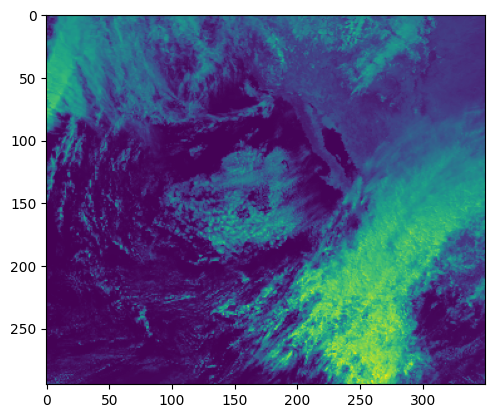

In [26]:
array = data.read()
plt.imshow(array[0])

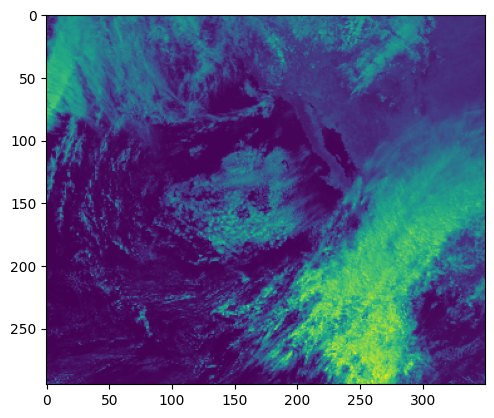

In [27]:
plt.imshow(array[1])

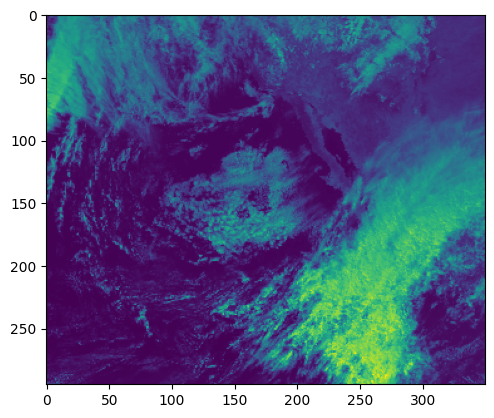

In [29]:
plt.imshow(array[0]*0.45 + array[1]*0.10 + array[2]*0.45)

In [30]:
# def apply_scale_and_offset(image, NUM_BANDS=3):
#     # image = ee.Image(image)
#     bands = [None] * NUM_BANDS
    
#     for i in range(1, 17):
#         band_name = 'CMI_C' + str(100 + i)[-2:]
#         offset = ee.Number(image.get(band_name + '_offset'))
#         scale = ee.Number(image.get(band_name + '_scale'))
#         bands[(i - 1) * 2] = image.select(band_name).multiply(scale).add(offset)

#         dqf_name = 'DQF_C' + str(100 + i)[-2:]
#         bands[(i - 1) * 2 + 1] = image.select(dqf_name)
    
#     # Bah, Gunshor, Schmit, Generation of GOES-16 True Color Imagery without a
#     # Green Band, 2018. https://doi.org/10.1029/2018EA000379
#     # Green = 0.45 * Red + 0.10 * NIR + 0.45 * Blue
#     green1 = bands[RED_BAND_INDEX].multiply(0.45)
#     green2 = bands[VEGGIE_BAND_INDEX].multiply(0.10)
#     green3 = bands[BLUE_BAND_INDEX].multiply(0.45)
#     green = green1.add(green2).add(green3)
#     bands[GREEN_BAND_INDEX] = green.rename(GREEN)
    
#     return ee.Image(ee.Image(bands).copyProperties(image, image.propertyNames()))

In [ ]:
# Plot the four bands: Band 2 (Red), Band 3 (NIR "Veggie"), "True" Green, and Band 1 (Blue)
fig, ([ax1, ax2, ax3, ax4]) = plt.subplots(1, 4, figsize=(16, 3))

ax1.imshow(R_rescaled, cmap='Reds', vmax=1, vmin=0)
ax1.set_title('Red', fontweight='bold')
ax1.axis('off')

ax2.imshow(G, cmap='Greens', vmax=1, vmin=0)
ax2.set_title('NIR "Veggie"', fontweight='bold')
ax2.axis('off')

ax3.imshow(G_true, cmap='Greens', vmax=1, vmin=0)
ax3.set_title('"True" Green', fontweight='bold')
ax3.axis('off')

ax4.imshow(B, cmap='Blues', vmax=1, vmin=0)
ax4.set_title('Blue', fontweight='bold')
ax4.axis('off')

plt.subplots_adjust(wspace=.02)

In [16]:
cProfile.run('qaqc_unusual_gaps(df, plots=True, verbose=True)')

         100859647 function calls (99167604 primitive calls) in 471.108 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    41472    0.022    0.000    0.257    0.000 <__array_function__ internals>:177(all)
        4    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(append)
    10370    0.007    0.000    0.045    0.000 <__array_function__ internals>:177(argsort)
    20740    0.014    0.000    0.119    0.000 <__array_function__ internals>:177(array_equal)
    10370    0.005    0.000    0.039    0.000 <__array_function__ internals>:177(atleast_2d)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(bincount)
    41472    0.019    0.000    0.310    0.000 <__array_function__ internals>:177(broadcast_to)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(can_cast)
    62217    0.036    0.000    0.192    0.000 <__array_function__ internals>:177(concate

In [19]:
from pycallgraph2 import PyCallGraph
from pycallgraph2.output import GraphvizOutput

with PyCallGraph(output=GraphvizOutput()):
    qaqc_unusual_gaps(df, plots=True, verbose=True)


KeyboardInterrupt



In [54]:
#-----------------------------------------------------------------------------
def qaqc_dist_var_bypass_check_profile(df, vars_to_check, min_num_months=5):     
    for var in vars_to_check:
        for month in range(1,13):
            print(var, month)
    return df

In [56]:
#-----------------------------------------------------------------------------
def qaqc_dist_gap_part1_profile(df, vars_to_check, iqr_thresh, plot=True, verbose=False):
    
    for var in vars_to_check:
        for month in range(1,13):
            print(var, month)
            # per variable bypass check
            df = qaqc_dist_var_bypass_check_profile(df, vars_to_check) # flag here is 20
            # if 20 in df[var+'_eraqc']:
            #     # print("skip")
            #     continue # skip variable

            # station has above min_num_months number of valid observations, proceed with dist gap check
            # else:
            if True:
                # valid obs only
                df_valid = df.loc[df[var+'_eraqc'].isnull() == True]

                # calculate monthly climatological median, and bounds
                # mid, low, high = standardized_median_bounds(df_valid, month, var, iqr_thresh=iqr_thresh)

                # calculate monthly median per month
                df_month = monthly_med(df_valid)

                for i in df_month.loc[df_month['month'] == month][var]:
                    print(i,month)
                    # if (i < low) or (i > high):
                    #     year_to_flag = (df_month.loc[(df_month[var]==i) & 
                    #                        (df_month['month']==month)]['year'].values[0])
                    #     printf('Median {} value for {}-{} is beyond the {}*IQR limits -- flagging month'.format(
                    #         var,
                    #         month, 
                    #         int(year_to_flag),
                    #         iqr_thresh), log_file=log_file, verbose=verbose
                    #     )

                        # flag all obs in that month
                        # df.loc[(df_valid['time'].dt.month == month) & 
                        #        (df_valid['time'].dt.year == year_to_flag), var+'_eraqc'] = 21 # see era_qaqc_flag_meanings.csv
                        #           network=df['station'].unique()[0].split('_')[0])
                
    return df


In [ ]:
qaqc_dist_gap_part1_profile(df, vars_to_check, iqr_thresh)

In [112]:
df.groupby(by=["month"])['year'].unique().apply(len)

month
1     11
2     11
3     12
4     14
5     15
6     17
7     17
8     19
9     19
10    18
11    13
12    13
Name: year, dtype: int64

In [266]:
var = "tas"
df[[var, "month","year"]].groupby(by=[ "month","year"]).count().groupby("month").count()

,tas
month,
1,11
2,11
3,12
4,14
5,15
6,17
7,17
8,19
9,19


In [222]:
def whole_stn_bypass_check(df, var):
    return df.loc[:,[var, "month","year"]].groupby(by=["month"])['year'].unique().apply(len)

In [223]:
%timeit whole_stn_bypass_check(df, var="tas")

2.72 ms ± 57.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [225]:
%timeit map(whole_stn_bypass_check, [df]*len(vars_to_check), vars_to_check)

152 ns ± 1.93 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [246]:
np.array(list(map(whole_stn_bypass_check, [df]*len(vars_to_check), vars_to_check)))

array([[11, 11, 12, 14, 15, 17, 17, 19, 19, 18, 13, 13],
       [11, 11, 12, 14, 15, 17, 17, 19, 19, 18, 13, 13],
       [11, 11, 12, 14, 15, 17, 17, 19, 19, 18, 13, 13],
       [11, 11, 12, 14, 15, 17, 17, 19, 19, 18, 13, 13],
       [11, 11, 12, 14, 15, 17, 17, 19, 19, 18, 13, 13]])

In [251]:
[1,2,3].count()

TypeError: list.count() takes exactly one argument (0 given)

In [244]:
stn_length = map(whole_stn_bypass_check, [df]*len(vars_to_check), vars_to_check)
stn_length = {k:v for k,v in zip(vars_to_check, stn_length)}
stn_length


{'tas': month
 1     11
 2     11
 3     12
 4     14
 5     15
 6     17
 7     17
 8     19
 9     19
 10    18
 11    13
 12    13
 Name: year, dtype: int64,
 'pr': month
 1     11
 2     11
 3     12
 4     14
 5     15
 6     17
 7     17
 8     19
 9     19
 10    18
 11    13
 12    13
 Name: year, dtype: int64,
 'rsds': month
 1     11
 2     11
 3     12
 4     14
 5     15
 6     17
 7     17
 8     19
 9     19
 10    18
 11    13
 12    13
 Name: year, dtype: int64,
 'sfcWind': month
 1     11
 2     11
 3     12
 4     14
 5     15
 6     17
 7     17
 8     19
 9     19
 10    18
 11    13
 12    13
 Name: year, dtype: int64,
 'tdps_derived': month
 1     11
 2     11
 3     12
 4     14
 5     15
 6     17
 7     17
 8     19
 9     19
 10    18
 11    13
 12    13
 Name: year, dtype: int64}

In [243]:
tmp

{'tas': month
 1     11
 2     11
 3     12
 4     14
 5     15
 6     17
 7     17
 8     19
 9     19
 10    18
 11    13
 12    13
 Name: year, dtype: int64,
 'pr': month
 1     11
 2     11
 3     12
 4     14
 5     15
 6     17
 7     17
 8     19
 9     19
 10    18
 11    13
 12    13
 Name: year, dtype: int64,
 'rsds': month
 1     11
 2     11
 3     12
 4     14
 5     15
 6     17
 7     17
 8     19
 9     19
 10    18
 11    13
 12    13
 Name: year, dtype: int64,
 'sfcWind': month
 1     11
 2     11
 3     12
 4     14
 5     15
 6     17
 7     17
 8     19
 9     19
 10    18
 11    13
 12    13
 Name: year, dtype: int64,
 'tdps_derived': month
 1     11
 2     11
 3     12
 4     14
 5     15
 6     17
 7     17
 8     19
 9     19
 10    18
 11    13
 12    13
 Name: year, dtype: int64}